In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('../') # add the root folder to the path

from diffusion_model.backward_module import BackwardModule
from diffusion_model.forward_module import ForwardModule
from diffusion_model.scheduler import Scheduler
from diffusion_model.models import UNetNoiseModel
from diffusion_model.datasets import get_mnist_dataset
from diffusion_model.constants import device

from torch.utils.data import DataLoader

from einops import rearrange

import matplotlib.pyplot as plt
import matplotlib

In [4]:
FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Datasets

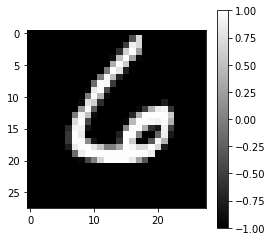

In [7]:
N_SAMPLES = 1000

dataset = get_mnist_dataset(N_SAMPLES)
dim = tuple(dataset[0].shape)

plt.imshow(dataset[0].cpu(), cmap='gray')
plt.colorbar();

# Plot helpers

In [14]:
def plot_evolutions(xs_t, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs_t), figsize=(FIG_SIZE*len(xs_t), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs_t)-1)
        ax.imshow(xs_t[i], cmap='gray')
        ax.set_title(f"{progress*100:.0f}%")
    plt.show()

# Diffusion model

In [15]:
T = 100

scheduler = Scheduler(input_dim=dim, nb_steps=T)
forward_module = ForwardModule(scheduler=scheduler)
noise_model = UNetNoiseModel(forward_module=forward_module, scheduler=scheduler)
backward_module = BackwardModule(forward_module=forward_module, scheduler=scheduler, noise_model=noise_model)

## Forward

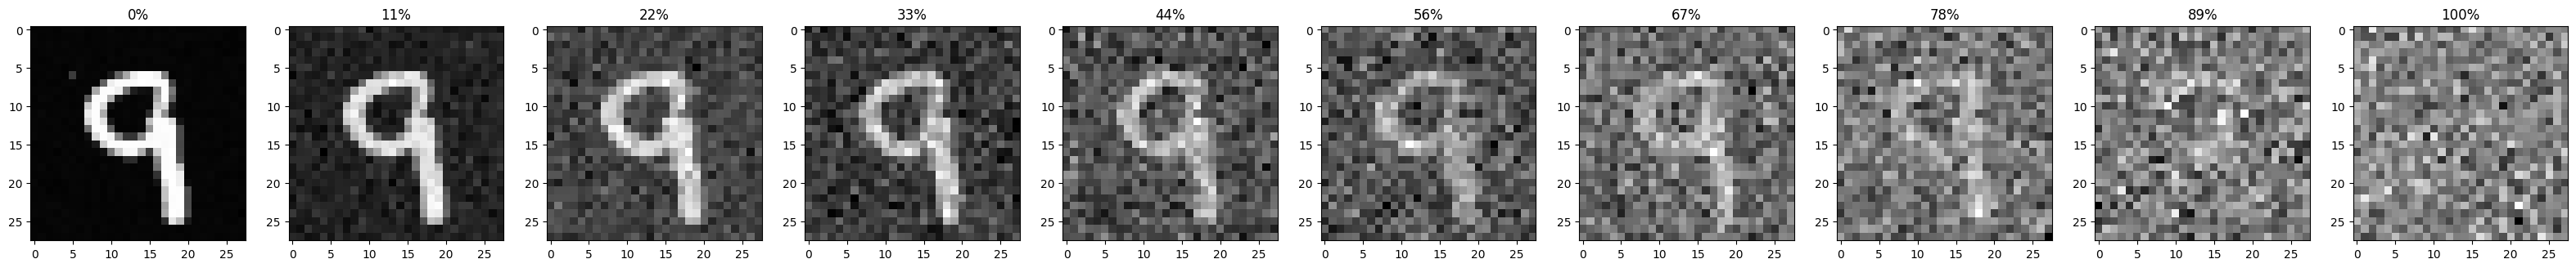

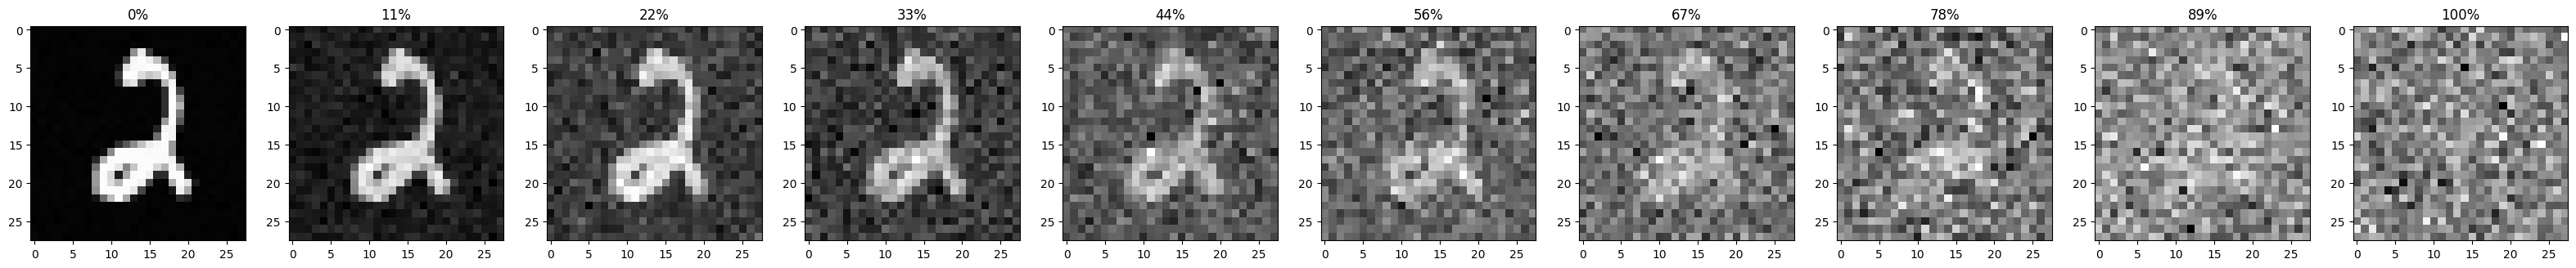

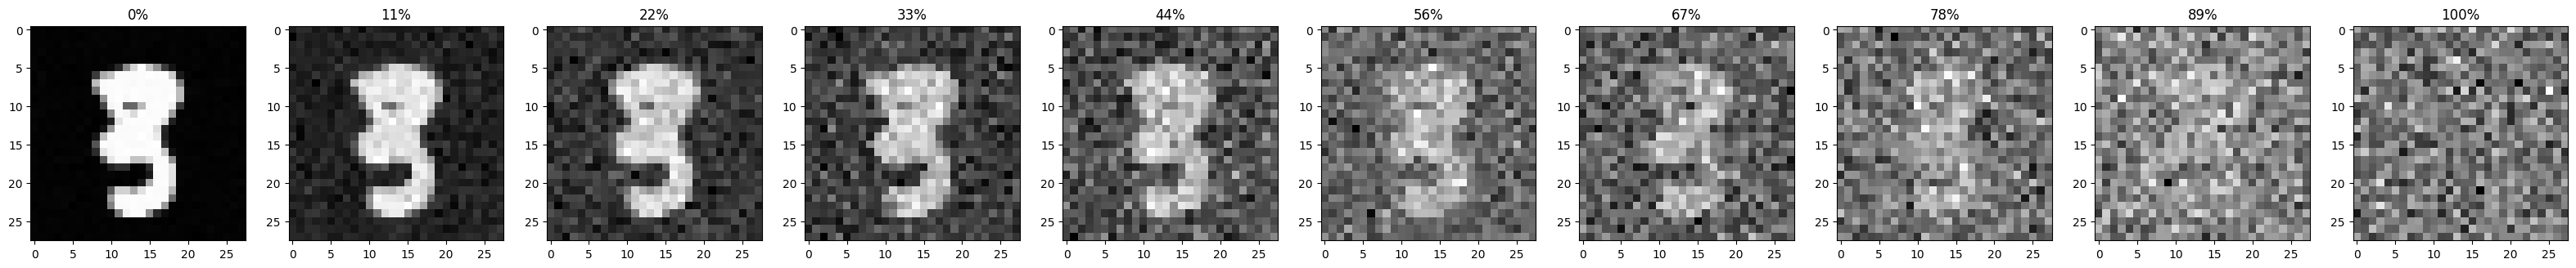

In [16]:
NB_DISPLAYED = 10
NB_EXAMPLES = 3

xs = dataset[:NB_EXAMPLES]
xs = forward_module.loop_forward(xs, nb_displayed_steps=NB_DISPLAYED)
xs = rearrange(xs, "t n h w -> n t h w")
for x in xs:
    plot_evolutions(x)

## Train the noise model

  0%|          | 0/100 [00:00<?, ?it/s]

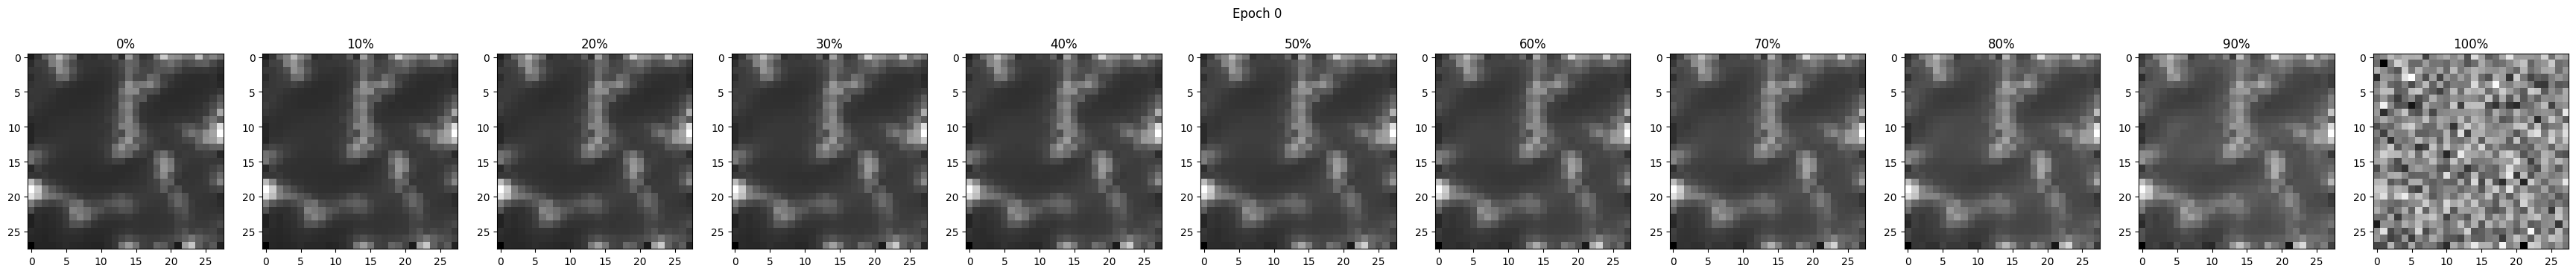

 10%|█         | 10/100 [01:17<11:54,  7.94s/it]

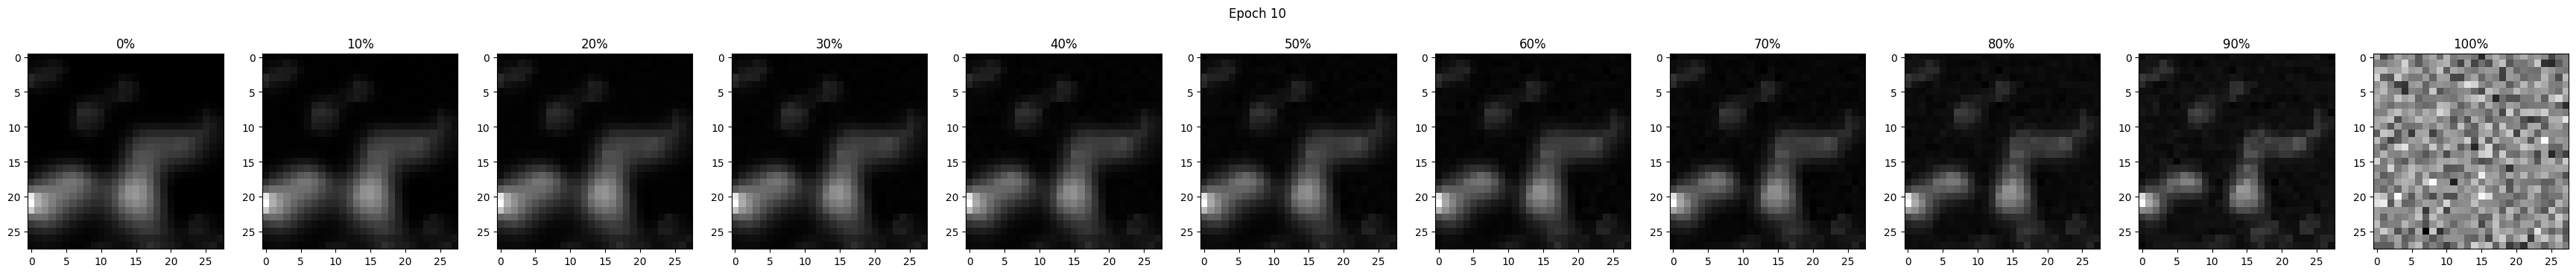

 20%|██        | 20/100 [02:31<09:53,  7.42s/it]

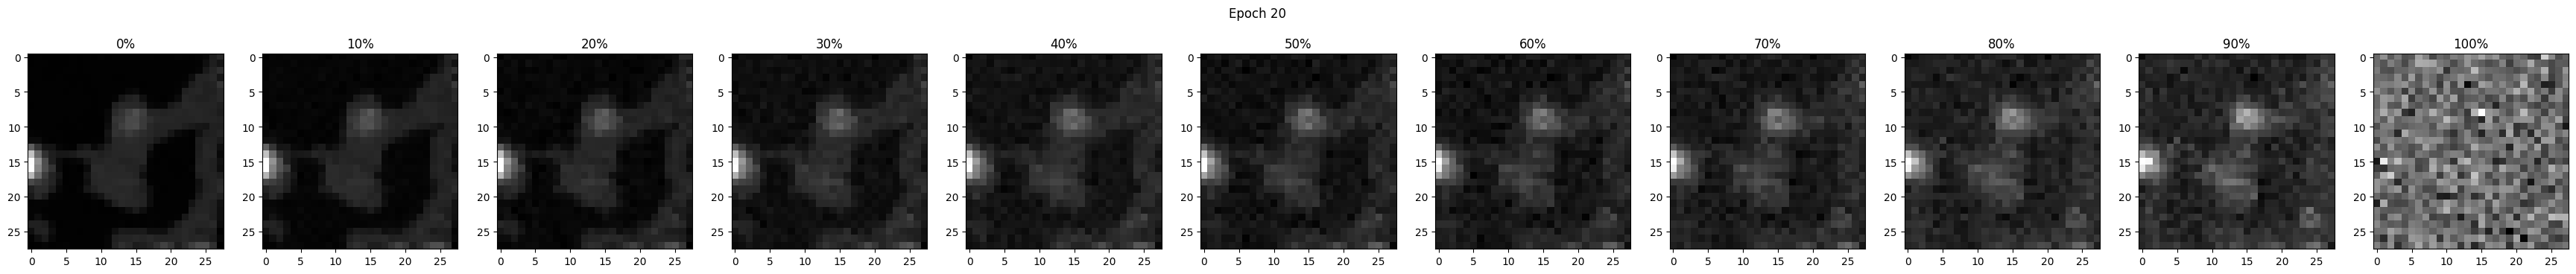

 30%|███       | 30/100 [03:45<08:35,  7.37s/it]

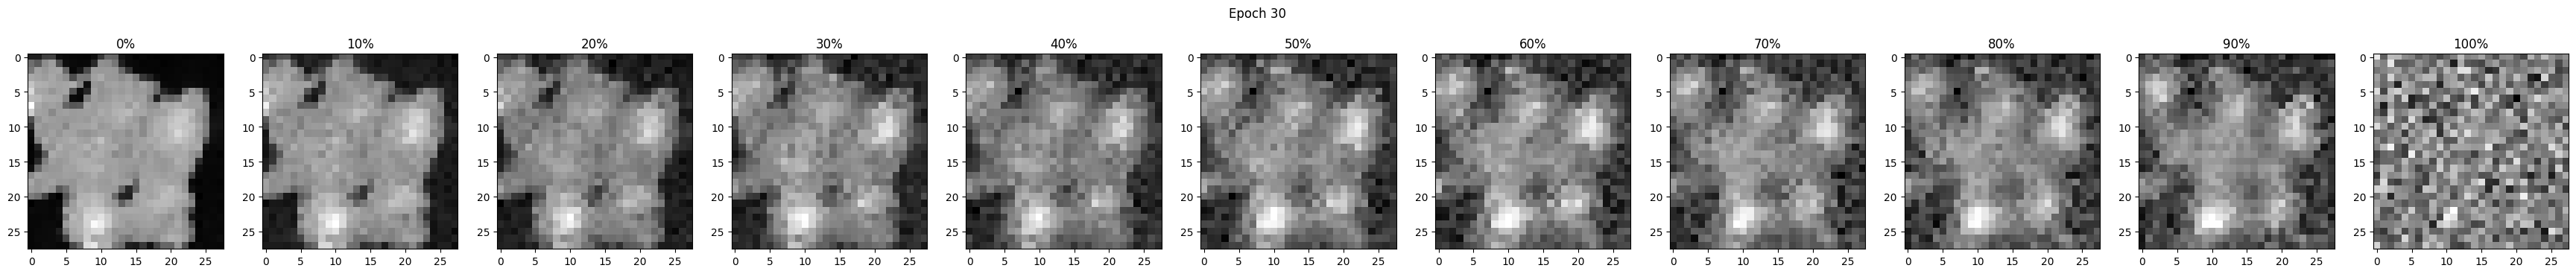

 40%|████      | 40/100 [05:00<07:23,  7.39s/it]

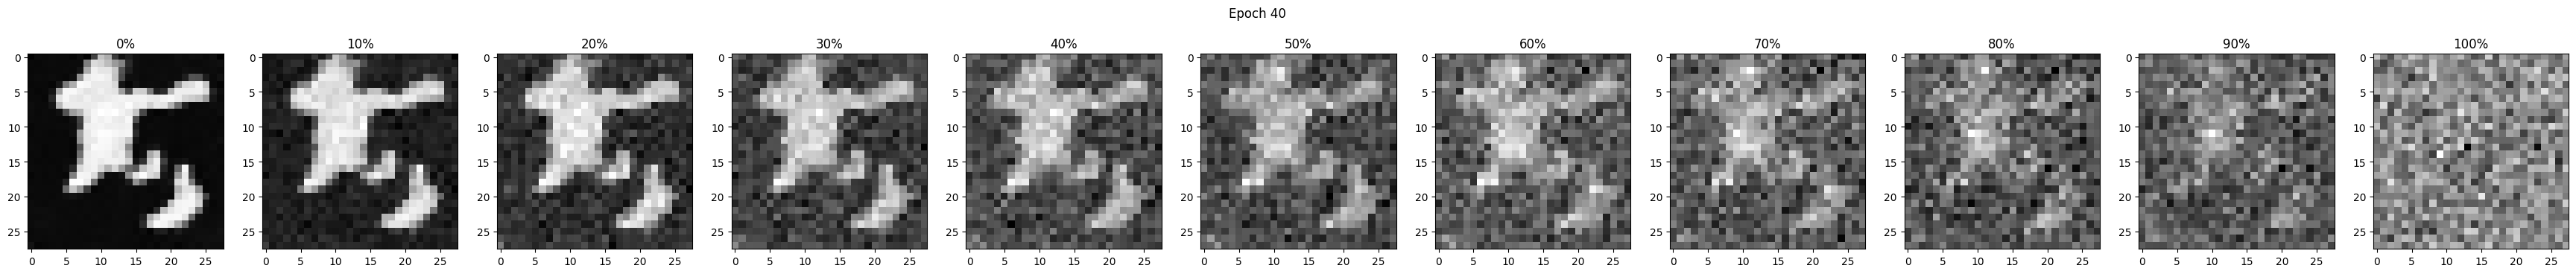

 50%|█████     | 50/100 [06:14<06:05,  7.32s/it]

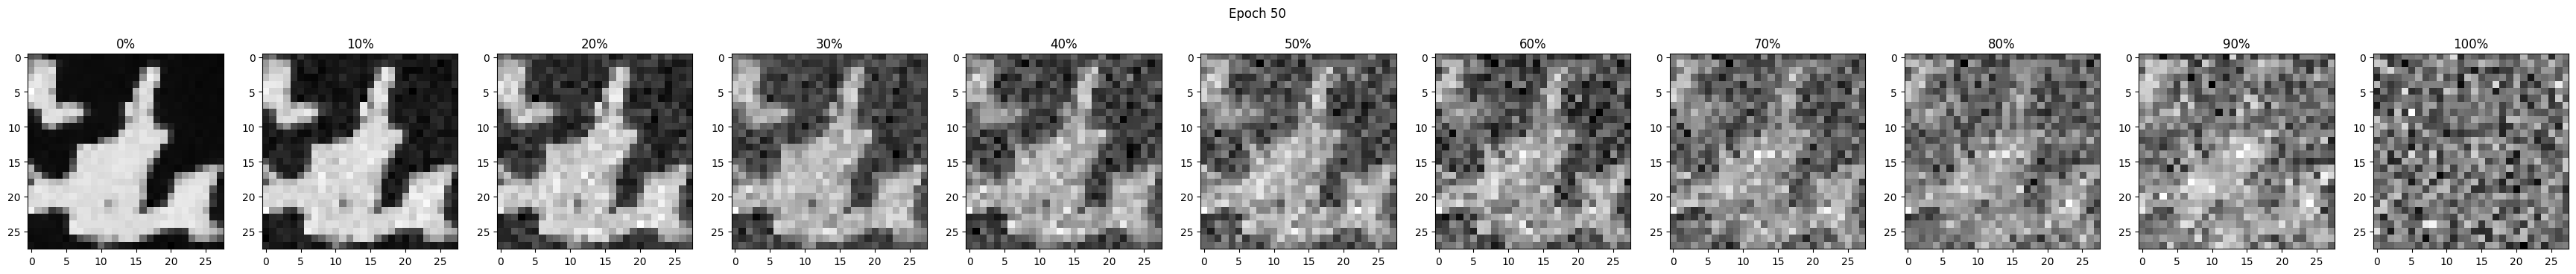

 60%|██████    | 60/100 [07:29<04:54,  7.36s/it]

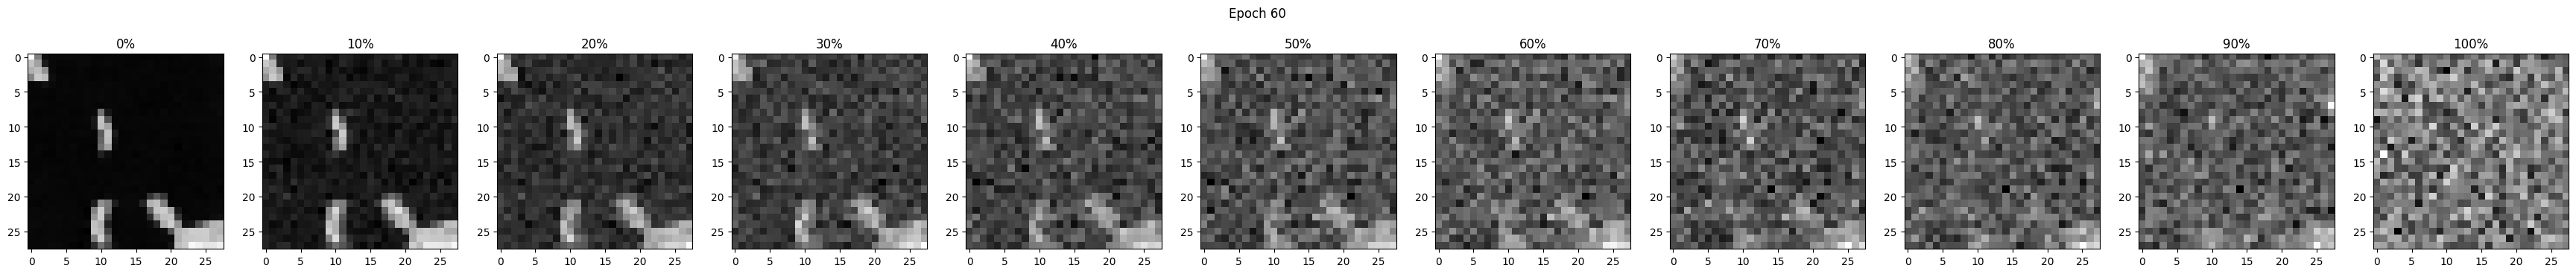

 70%|███████   | 70/100 [08:44<03:43,  7.45s/it]

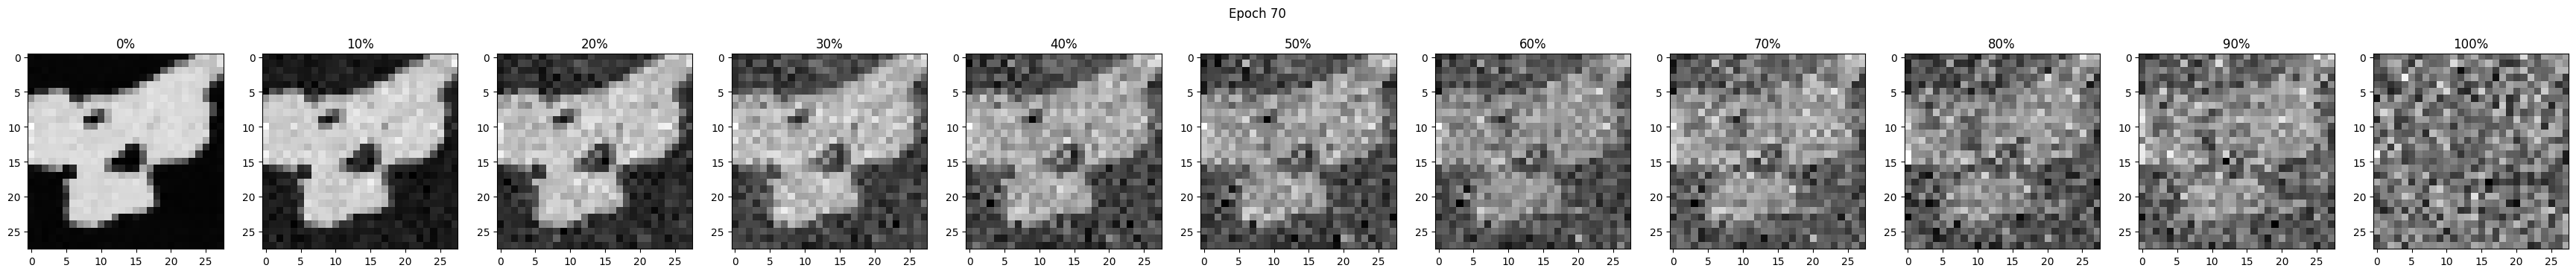

 80%|████████  | 80/100 [09:58<02:27,  7.37s/it]

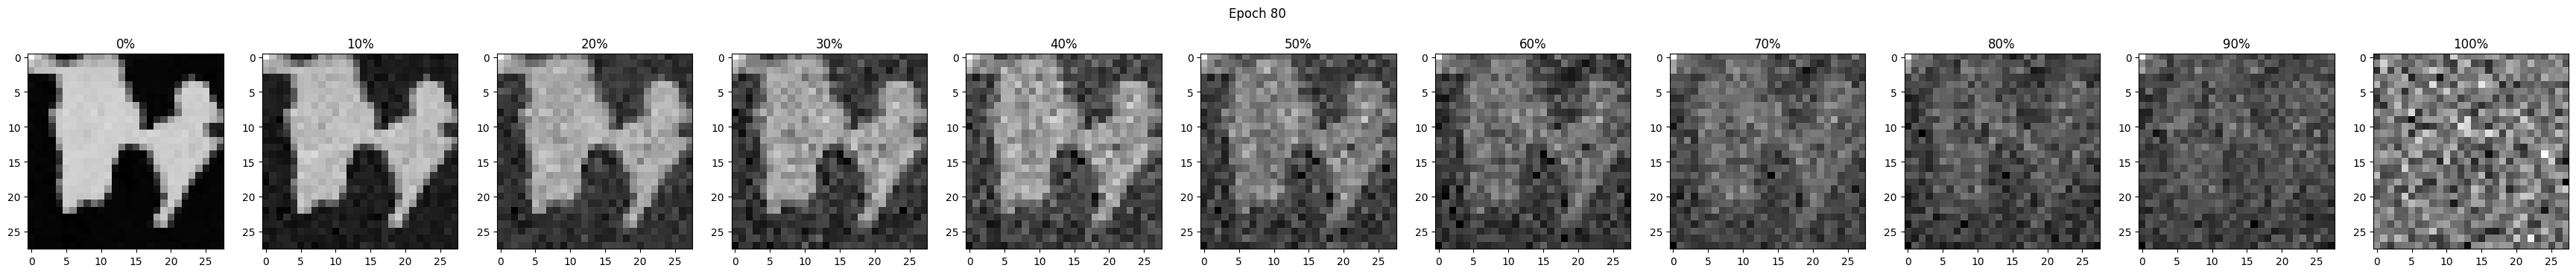

 83%|████████▎ | 83/100 [10:23<02:07,  7.51s/it]


KeyboardInterrupt: 

In [18]:
BATCH_SIZE = 32
NB_EPOCHS = 100

def display_evolutions(epoch, *_):
    xs_t = backward_module.loop_backward(n_sample=1, nb_displayed_steps=NB_DISPLAYED)
    x_t = rearrange(xs_t, "t 1 h w -> t h w")
    plot_evolutions(x_t, title=f"Epoch {epoch}")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
noise_model.fit(dataloader, nb_epochs=NB_EPOCHS, logger=display_evolutions)
display_evolutions(NB_EPOCHS)

## Backward

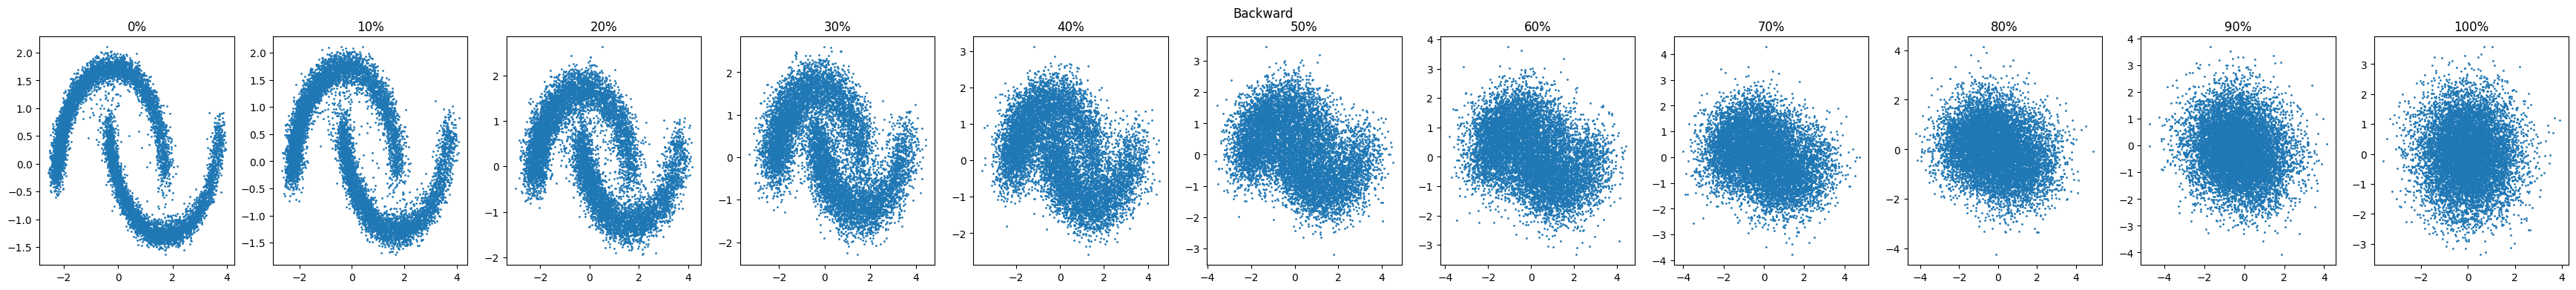

In [ ]:
xs_t = backward_module.loop_backward(n_sample=N_SAMPLES, nb_displayed_steps=NB_DISPLAYED)
plot_evolutions(xs_t, title="Backward")